In [5]:
%matplotlib inline

import gym
import torch
from torch import nn
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

## Create Environment using GYM

In [6]:
env = gym.make('CartPole-v1')

state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

print('Env Created:\nState Size: %d\tActions Size: %d' %(state_space_size, action_space_size))

Env Created:
State Size: 4	Actions Size: 2


## Create Agent -> A simple policy network

In [12]:
class A2CAgent(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(A2CAgent, self).__init__()
        
        # craete network
        self.policy_net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=1)
        )
        
        self.value_network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def get_action(self, state):
        state = torch.tensor([state])
        
        return Categorical(self.policy_net(state)), self.value_network(state)
    
    def get_policy_info(self, action, state):
        state = torch.tensor([state])
        actions_dist = Categorical(self.policy_net(state))
        
        selected_action_log_prob = actions_dist.log_prob(action)
        policy_entropy = actions_dist.entropy()
        
        state_value = self.value_network(state)
        
        return selected_action_log_prob, policy_entropy, state_value

## Training part

Update using the following formula:

$L = L^{CLIP} - c_1 (V(s_t) - V^{trgt}) ^ 2 + c_2 S$

where $S$ is policy entropy and $V^{trgt}$ can be the advantage. The $L^{CLIP}$ can be calculated using:

$L^{CLIP} = min( r_t A_t, clip(r_t, 1-\epsilon, 1+\epsilon) A_t )$

where $r_t = \frac{\pi(a_t|s_t)}{\pi_{old}(a_t|s_t)}$

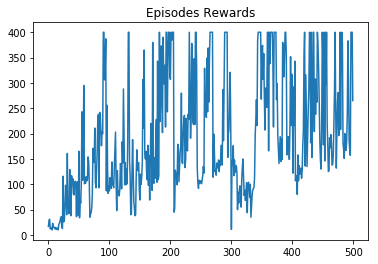

In [53]:
GAMMA           = 0.99
LR              = 0.001
MAX_EPISODES    = 500
TERMINAL_TIME   = 400
EPSILON_CLIP = 0.2

agent = A2CAgent(state_space_size, action_space_size, 100).double()
agent_old = A2CAgent(state_space_size, action_space_size, 100).double()
optimizer = torch.optim.Adam(agent.parameters(), lr=LR)
episode_rewards = []

agent.train()

for episode_no in range(MAX_EPISODES):
    rewards = []
    action_probs = []
    actions = []
    state_values = []
    states = []
    
    done = False
    current_state = env.reset()
    current_time = 0
    
    # go through an episode
    while done != True and current_time != TERMINAL_TIME:
        # get action
        action_dist, state_value = agent_old.get_action(current_state)
        action = action_dist.sample()
        
        next_state, reward, done, _ = env.step(action.item())
        
        # save
        rewards.append(reward)
        actions.append(action)
        action_probs.append(action_dist)
        state_values.append(state_value)
        states.append(current_state)
        
        # go next
        current_state = next_state
        current_time += 1
    
    ## update the agent after an episode or certain amount of time
    if done:
        R = 0
    else:
        R = state_value.item()
    
    # calculate loss value
    for k in range(5):
        for t in range(current_time - 1, -1, -1):
            # find A_t
            R = (rewards[t] + GAMMA * R)

            # update policy network
            action_prob, S, state_val = agent.get_policy_info(actions[t], states[t])

            r_t = torch.exp(action_prob - action_probs[t].log_prob(actions[t]).item())
            
            # 3 models for L -> L_clip, no clipping, KL penalty (https://arxiv.org/pdf/1707.06347.pdf)
            L_clip = r_t * (R - state_val)
            #L_clip = torch.min(torch.tensor([
            #    r_t * (R - state_val),
            #    torch.clamp(r_t, 1.0 - EPSILON_CLIP, 1.0 + EPSILON_CLIP) * (R - state_val)    
            #]))
            value_loss = (state_val - R) ** 2

            loss = -(L_clip - 0.8 * value_loss + 0.01 * S)

            # update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        agent_old.load_state_dict(agent.state_dict())
        
    # print 
    episode_rewards.append(np.sum(rewards))
    
    if episode_no % 50 == 0:
        print('[%d/%d] Mean Reward = %0.2f   Max Reward = %d\t\t\t' %(episode_no, MAX_EPISODES, np.mean(episode_rewards[-50:]), np.max(episode_rewards[-50:])), end='\r', flush=True)
        
# plot each episode's total reward
plt.plot(episode_rewards)
plt.title('Episodes Rewards')
plt.show()

## Test the agent

In [55]:
agent_old.eval()
done = False
current_state = env.reset()
rewards = []

# go through an episode
while not done:
    # render env
    env.render()
    
    # get BEST action based on the log probabilities -> argmax on them
    action_dist, _ = agent_old.get_action(current_state)
    log_probs = []
    
    for i in range(action_space_size):
        log_probs.append(action_dist.log_prob(torch.tensor(i)).item())
        
    # perform action
    next_state, reward, done, _ = env.step(np.argmax(log_probs))

    rewards.append(reward)
    
    current_state = next_state
    
env.close()

print('Total Reward = %d' %(np.sum(rewards)))

Total Reward = 359


In [56]:
# benchmark!
agent_old.eval()
episode_rewards = []

for i in range(100):
    done = False
    current_state = env.reset()
    rewards = []

    # go through an episode
    while not done:
        # get BEST action based on the log probabilities -> argmax on them
        action_dist, _ = agent_old.get_action(current_state)
        log_probs = []

        for i in range(action_space_size):
            log_probs.append(action_dist.log_prob(torch.tensor(i)).item())

        # perform action
        next_state, reward, done, _ = env.step(np.argmax(log_probs))

        rewards.append(reward)

        current_state = next_state

    episode_rewards.append(np.sum(rewards))
    
print('Min = %d   Max = %d   Mean = %0.2f' %(np.min(episode_rewards), np.max(episode_rewards), np.mean(episode_rewards)))

if np.min(episode_rewards) > 198:
    print('Solved :)')

Min = 144   Max = 500   Mean = 362.27
